In [2]:
%matplotlib inline

import random
import operator
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
import networkx.algorithms.isomorphism as iso
from scipy import stats
from functools import reduce 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.estimators.base import ParameterEstimator
from pgmpy.factors.discrete.CPD import TabularCPD
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib inline 
#pd.set_option('display.max_rows', 200)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 10000)

/opt/conda/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/conda/lib/python3.8/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [6]:
df = pd.read_csv("./audiology.standardized-discretized.csv")
df.drop(axis=1, index=69)
df = df.sample(frac=1)

In [7]:
class Data_Testing:
    def __init__(self, df=None):
        self.df = df
        
    def get_dataframe(self):
        return self.df
        
    def update_data(self, df):
        self.df = df
        
    def get_kfold_train_test(self, splits=3):
        cv = KFold(n_splits=splits, shuffle=False)
        for train_index, test_index in cv.split(df):
            df_train = df.iloc[train_index,:]
            df_test = df.iloc[test_index,:]
            yield {'df_train': df_train, 'df_test': df_test}
    
    def get_number_of_cats(self, col):
        cats = self.get_cats(col)

        return len(cats)
    
    def get_cats(self, col):
        values = np.sort(self.df.loc[:,col].value_counts().index.to_numpy())
        return values

    def get_total_number_of_cross_cols(self, samples, cols=[]):
        col_nums = []
    
        for col in cols:
            col_n = self.df.iloc[0:samples,col].value_counts().size
            col_nums.append(col_n)
        
        result = reduce((lambda x, y: x * y), col_nums) 
    
        return result
    
    def get_data_from_source(self, data, target, cols=[]):
        ds_target = data.loc[:,target]
        ds_cols = []
        
        for col in cols:
            col1 = data.loc[:,col]
            ds_cols.append(col1)
        ds_ret = {"ds_target": ds_target, "ds_cols": ds_cols} #Return target series and array of col series
    
        return ds_ret
    
    def get_cat_data_from_source(self, data, target, cols=[]):
        ds_target = pd.Categorical(data.loc[:,target], self.get_cats(target))
        ds_cols = []
        
        for col in cols:
            col1 = pd.Categorical(data.loc[:,col], self.get_cats(col))
            ds_cols.append(col1)
        ds_ret = {"ds_target": ds_target, "ds_cols": ds_cols} #Return target series and array of col series
    
        return ds_ret

    def get_data(self, target, cols=[]):
        ds_ret = self.get_data_from_source(self.df, target, cols)
    
        return ds_ret

    def create_crosstab(self, data):
        crosstab = pd.crosstab(data['ds_target'],data['ds_cols']) #,margins=True
        return crosstab
    
    def create_tabular_CPD(self, data, target, cols=[]):
        cpd = None
        
        if len(cols) < 1:
            cpd = self.create_marginal_tabular_probability_distribution(data, target)
            #print("Marginal: " + str(target) + " " + str(cols))
        else:
            cpd = self.create_conditional_tabular_probability_distribution(data, target, cols)
            #print("Conditional: " + str(target) + " " + str(cols))
        
        return cpd
    
    def create_conditional_tabular_probability_distribution(self, data, target, cols=[]):
        number_of_categories = []
        processed_data = self.get_cat_data_from_source(data, target, cols)
        #tab = pd.crosstab(processed_data['ds_target'],processed_data['ds_cols'],normalize=True)
        tab = pd.crosstab(processed_data['ds_target'],processed_data['ds_cols'],rownames=[target], colnames=cols,normalize=True,dropna=False)
        #tab.iloc[0,0] = tab.iloc[0,0] + (1-sum(tab.to_numpy().flatten()))
        tabnp = tab.to_numpy()
        
        for col in cols:
            number_of_categories.append(self.get_number_of_cats(col))
            
        tp = TabularCPD(target, len(tabnp), tabnp, evidence=cols, evidence_card=number_of_categories)
        
        return tp
    
    def create_marginal_tabular_probability_distribution(self, data, target):
        pds = data[target]
        tab = pds.value_counts(normalize=True)
        for val in self.get_cats(target):
            if val not in tab.index:
                #tab.reindex([val],fill_value=0)
                tab = tab.append(pd.Series([0], index=[val]))
        tab = tab.sort_index()
        tab = tab.to_numpy()
        tab = np.reshape(tab, (len(tab),1))
        
        tp = TabularCPD(target, len(tab), tab)
        
        return tp

    def g_test(self, samples, target, cols=[]):
        results = None
        data = self.get_data(target, cols)
        con = pd.crosstab(data['ds_target'],data['ds_cols']) #,margins=True
        results = stats.chi2_contingency(con, lambda_="log-likelihood")
        return results[1]

    def chi_test(self, samples, target, cols=[]):
        results = None
        data = self.get_data(target, cols)
        con = pd.crosstab(data['ds_target'],data['ds_cols']) #,margins=True
        results = stats.chi2_contingency(con)
        return results[1]


Population size: 99
Refset size: 40


100%|██████████| 5/5 [00:00<00:00, 3305.20it/s]

Number of iterations: 100
Last refset update count: 0
Refset size: 136
Refset size: 116



100%|██████████| 3/3 [00:00<00:00, 2690.38it/s]


{'accuracy': 0.77, 'roc': 0, 'recall': 0.77, 'precision': 0.7043960614548851}
Number of nodes: 6
Probability prediction not possible
multiclass-multioutput format is not supported
Probability prediction not possible
multiclass-multioutput format is not supported


100%|██████████| 5/5 [00:00<00:00, 3167.42it/s]

Probability prediction not possible
multiclass-multioutput format is not supported
Accuracy: 0.65
Accuracy: 0.5
Accuracy: 0.49



100%|██████████| 3/3 [00:00<00:00, 2067.86it/s]


--------



--------
Total runtime: 0:28:50.656724
Probability prediction not possible
multiclass-multioutput format is not supported
Probability prediction not possible
multiclass-multioutput format is not supported
Probability prediction not possible
multiclass-multioutput format is not supported
{'accuracy': 0.545, 'roc': 0, 'recall': 0.545, 'precision': 0.51193245832182}
Nodes: 9 Edges: 8


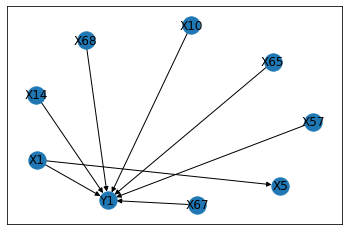

{'accuracy': 0.425, 'roc': 0, 'recall': 0.425, 'precision': 0.3049670329670329}
Nodes: 5 Edges: 4


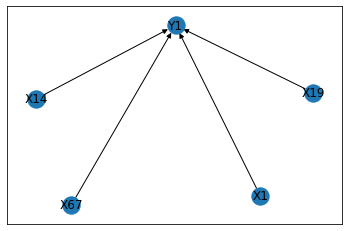

{'accuracy': 0.41, 'roc': 0, 'recall': 0.41, 'precision': 0.35909217786432973}
Nodes: 7 Edges: 6


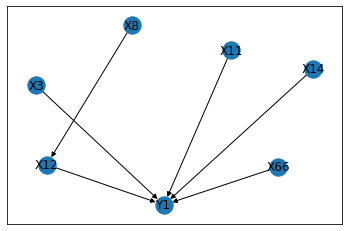

-----------Top three graphs-----------
Probability prediction not possible
multiclass-multioutput format is not supported
Probability prediction not possible
multiclass-multioutput format is not supported
Probability prediction not possible
multiclass-multioutput format is not supported
{'accuracy': 0.545, 'roc': 0, 'recall': 0.545, 'precision': 0.51193245832182}
{'accuracy': 0.425, 'roc': 0, 'recall': 0.425, 'precision': 0.3049670329670329}
{'accuracy': 0.41, 'roc': 0, 'recall': 0.41, 'precision': 0.35909217786432973}
-----------Top three graphs-----------
{'V': 9, 'E': 8}
{'V': 5, 'E': 4}
{'V': 7, 'E': 6}
-----------Top three graphs-----------
---------------Accuracy(ms)-----------
{'graph-1': 555.893, 'graph-2': 10.144, 'graph-3': 91.284}
-----------Top three graphs-----------
-----------------ROC(ms)--------------
{'graph-1': 555.893, 'graph-2': 10.144, 'graph-3': 91.284}
-----------Top three graphs-----------
---------------Recall(ms)-------------
{'graph-1': 555.893, 'graph-2': 1

In [17]:
class Scatter_Search:
    
    class Metrics:
        def __init__(self, solutions):
            self.solutions = solutions
            
        def sort_solutions(self, metric='accuracy'):
            self.solutions = sorted(self.solutions, key=lambda solution: solution.get_metrics(metric=metric), reverse=True)
        
        def calculate_top_3_graph_roc(self):
            for solution in self.solutions[0:3]:
                solution.get_bayesian_model().calculate_roc_score()
        
        def get_top_3_graphs(self):
            self.sort_solutions()
            self.calculate_top_3_graph_roc()
            return self.solutions[0:3]
        
        def get_top_graph_all_metrics(self, metric='accuracy'):
            self.sort_solutions(metric)
            return self.solutions.get_metrics()
        
        def get_number_of_nodes_edges(self, total_graphs=3, metric='accuracy'):
            graph_VE_metrics = []
            self.sort_solutions(metric)
            
            for i in range(0,total_graphs):
                v = self.solutions[i].get_number_of_nodes()
                e = self.solutions[i].get_number_of_edges()
                ve_metric = {'V': v, 'E': e}
                graph_VE_metrics.append(ve_metric)
                
            return graph_VE_metrics
        
        def get_top_graphs_time(self, total_graphs=3, metric='accuracy'):
            graph_times = {}
            self.sort_solutions(metric)
            for i in range(0,total_graphs):
                graph_times['graph-'+str(i+1)] = self.solutions[i].get_bayesian_model().get_total_time().microseconds/1000
            
            return graph_times
        
    class Reporting:
        def __init__(self, metrics_handler):
            self.mh = metrics_handler
            
        def print_report_1(self):
            print("-----------Top three graphs-----------")
            for solution in self.mh.get_top_3_graphs():
                print(solution.get_metrics())
            print("-----------Top three graphs-----------")
            for metric in self.mh.get_number_of_nodes_edges(total_graphs=3,metric='accuracy'):
                print(metric)
            print("-----------Top three graphs-----------")
            print("---------------Accuracy(ms)-----------")
            print(self.mh.get_top_graphs_time(total_graphs=3, metric='accuracy'))
            print("-----------Top three graphs-----------")
            print("-----------------ROC(ms)--------------")
            print(self.mh.get_top_graphs_time(total_graphs=3, metric='roc'))
            print("-----------Top three graphs-----------")
            print("---------------Recall(ms)-------------")
            print(self.mh.get_top_graphs_time(total_graphs=3, metric='recall'))
            print("-----------Top three graphs-----------")
            print("---------------Precision(ms)----------")
            print(self.mh.get_top_graphs_time(total_graphs=3, metric='precision'))
            
    
    class Solution:
        def __init__(self, graph, p_value):
            self.graph = graph
            self.p_value = p_value
            self.bn = Scatter_Search.Bayesian_Model(graph)
            
        def get_number_of_nodes(self):
            return self.bn.get_bayesian_model().number_of_nodes()
        
        def get_number_of_edges(self):
            return self.bn.get_bayesian_model().number_of_edges()
            
        def get_bayesian_model(self):
            return self.bn
            
        def get_graph(self):
            return self.graph
        
        def get_score(self):
            return self.p_value
        
        def get_training_time(self):
            return self.bn.total_training_time
        
        def get_metrics(self, metric=None):
            if metric is None:
                return self.bn.get_metrics()
            else:
                return self.bn.get_metrics()[metric]
            
        def update_graph_from_bayesian_model(self):
            self.graph = self.bn.create_networkx_graph()
    
    class Solution_Store:
        def __init__(self):
            self.solutions = []
            
        def get_solution_list_size(self):
            return len(self.solutions)
            
        def sort_by_score(self):
            self.solutions.sort(key=lambda sol: sol.get_score())
            
        def get_best_scoring(self):
            self.sort_by_score()
            return self.solutions[0].get_score()
        
        def get_worst_scoring(self):
            self.sort_by_score()
            return self.solutions[len(self.solutions)-1]
        
        def check_solution_is_in_population(self, new_solution):
            is_in_solutions = False
            if len(self.solutions) > 0:
                for solution in self.solutions:
                    nm = iso.categorical_node_match('name', 'name')
                    if nx.is_isomorphic(solution.get_graph(), new_solution.get_graph(), node_match=nm) == True:
                        is_in_solutions = True
                return is_in_solutions
            else:
                return is_in_solutions
        
        def check_solution_is_directed_acyclic_graph(self, new_solution):
            if (nx.is_directed_acyclic_graph(new_solution.get_graph()) == True):
                return True
            else:
                return False
            
        def add_solution_with_checks(self, new_solution):
            if self.check_solution_is_in_population(new_solution) == False:
                if self.check_solution_is_directed_acyclic_graph(new_solution) == True:
                    self.solutions.append(new_solution)
                    #print("Added!")
                    return True
                else:
                    pass
                    #print("Failed acyclic check")
            else:
                pass
                #print("Failed population check")
            return False
        
        def add_solution(self, new_solution):
            self.solutions.append(new_solution)
                
        def get_solution_set(self):
            return self.solutions
        
        def get_metrics_handler(self):
            return Scatter_Search.Metrics(self.solutions)
        
    class Population(Solution_Store):
        def __init__(self):
            super().__init__()
            
        def get_population_set(self):
            return self.get_solution_set()
        
    class RefSet(Solution_Store):
        def __init__(self):
            super().__init__()
            
        def add_new_solutions(self, solutions, number_of_solutions):
            i=0
            #print("Refset called, number of solutions: " + str(number_of_solutions))
            #print("Refset length of solution array: " + str(len(solutions)))
            for solution in solutions:
                i=i+1
                if i <= number_of_solutions:
                    self.add_solution_with_checks(solution)
                    #print("Adding solution to refset.....")
                else:
                    break
                    
        def clean_refset(self, target): #Remove any graph that doesn't have the target or connections to the target
            i=0
            new_solutions = []
            #print("Solution size: " + str(len(self.solutions)))
            for solution in self.solutions:
                has_target = solution.get_bayesian_model().get_bayesian_model().has_node(target)
                number_of_nodes = len(solution.get_bayesian_model().get_bayesian_model().in_edges(target))
                if ((number_of_nodes > 0) or (has_target is True)):
                    #print("Solution kept")
                    #print("Solution node found: " + str(has_target))
                    #print("Solution target: " + str(target))
                    #self.solutions.remove(solution)
                    new_solutions.append(solution)
                else:
                    pass
                    #print("Solution removed")
                    #print("Solution target: " + str(target))
                    #print("Solution node found: " + str(has_target))
                i=i+1
                #print(i)
            self.solutions = new_solutions
                    
        def run_fit_parameters_for_all_models(self):
            for solution in self.solutions:
                solution.get_bayesian_model().fit_parameters()
                    
        def get_random_solution(self, contains_node=None):
            i = 0
            index_max = (self.get_solution_list_size()-1)
            index = random.randint(0,index_max)
            if contains_node != None:
                while (self.solutions[index].get_graph().has_node(contains_node) == False) and (i < 10):
                    index = random.randint(0,index_max)
                    i=i+1
            if i > 9:
                return None
            else:
                return self.solutions[index]
            
        def find_best_solution(self, metric="accuracy"):
            best_fit_solution = self.solutions[0]
            
            for solution in self.solutions:
                metric1 = best_fit_solution.get_bayesian_model().get_metrics()[metric]
                metric2 = solution.get_bayesian_model().get_metrics()[metric]
                if metric2 > metric1:
                    best_fit_solution = solution
                    
            return best_fit_solution
        
    class TargetSolutions(RefSet):
        def __init__(self):
            super().__init__()
            
        def import_refset(self, refset):
            for solution in refset.get_solution_set():
                solution.update_graph_from_bayesian_model()
                self.add_solution_with_checks(solution)
            
        
        
    class Bayesian_Model:
        def __init__(self, graph, target='Y1'):
            self.bn = BayesianModel()
            self.graph = graph
            self.create_bayesian_network()
            self.metrics = {"accuracy": 0, "roc": 0, "recall": 0, "precision": 0}
            self.target = target
            self.start_training_time = 0
            self.total_training_time = 0
            
        def find_best_graph(self, models, metric):
            current_model = {"bn_model": None, "score": {"accuracy": 0, "roc": 0, "recall": 0, "precision": 0}}
            
            for model in models:
                '''print("Model var: " + str(model))
                print("Current model: " + str(current_model))'''
                if model['score'][metric] > current_model['score'][metric]:
                    current_model = model
                #print("cpds")
                #print(model['bn_model'].get_cpds())
            
            return current_model
        
        def get_state_names(self, cols=[]):
            state_names_dict = {}
            data = data_testing.get_dataframe()
            
            for col in cols:
                values = list(data[[col]].drop_duplicates().to_numpy().flatten())
                state_names_dict[col] = values
            
            return state_names_dict
        
        def fit_parameters(self, k_fold_splits=2, estimator='bayesian'):
            bn_models = []
            state_names_dict = {}
            self.set_start_training_time()
            self.trim_to_markov_blanket()
            for data in data_testing.get_kfold_train_test(splits=k_fold_splits):#This has been initalized as gobal in the scatter search init
                bn_model = self.bn.copy()
                if estimator == 'mle':
                    bn_model.fit(data['df_test'][list(bn_model.nodes)], state_names=self.get_state_names(bn_model.nodes))
                elif estimator == 'bayesian':
                    #estimator = BayesianEstimator(bn_model, data)
                    bn_model.fit(data['df_test'][list(bn_model.nodes)], estimator=BayesianEstimator, \
                                 state_names=self.get_state_names(bn_model.nodes), prior_type='K2')
                elif estimator == 'param':
                    #est = ParameterEstimator
                    bn_model.fit(data['df_test'][list(bn_model.nodes)], estimator=ParameterEstimator, \
                                 state_names=self.get_state_names(bn_model.nodes))
                score = self.score_network(bn_model, data['df_test'][list(bn_model.nodes)])
                bn_models.append({"bn_model": bn_model, "score": score})
            final_result = self.find_best_graph(bn_models, "accuracy")
            self.bn = final_result['bn_model']
            self.metrics = final_result['score']
            self.set_stop_training_time()
                
        def score_network(self, bn, test_data):
            if self.target in list(bn.nodes):
                td = test_data.drop(self.target, axis=1)
                predictions = bn.predict(td)
                '''try:
                    prob_predictions = bn.predict_probability(td).to_numpy()
                except ValueError:
                    print("Probability prediction not possible")
                
                try:
                    roc = roc_auc_score(test_data[self.target], prob_predictions, multi_class='ovr')
                except ValueError:
                    roc = 0'''
                accuracy = accuracy_score(test_data[self.target], predictions)
                roc = 0
                recall = recall_score(test_data[self.target], predictions, average='weighted')
                precision = precision_score(test_data[self.target], predictions, average='weighted', zero_division=0)
                scores = {"accuracy": accuracy, "roc": roc, "recall": recall, "precision": precision}
            else:
                scores = {"accuracy": 0, "roc": 0, "recall": 0, "precision": 0}
                
            return scores
        
        def score_network_over_all_data(self):
            nodes = list(self.bn.nodes)
            df = data_testing.get_dataframe()[nodes]
            target_data = df[self.target]
            prediction_df = df.drop(self.target, axis=1)
            predictions = self.bn.predict(prediction_df)
            '''try:
                prob_predictions = self.bn.predict_probability(prediction_df).to_numpy()
                roc = roc_auc_score(target_data, prob_predictions, multi_class='ovr')
            except ValueError as e:
                print("Probability prediction not possible")
                print(e)
                roc = 0'''
            roc = 0
            accuracy = accuracy_score(target_data, predictions)
            recall = recall_score(target_data, predictions, average='weighted')
            precision = precision_score(target_data, predictions, average='weighted', zero_division=0)
            
            self.metrics = {"accuracy": accuracy, "roc": roc, "recall": recall, "precision": precision}
            
        def calculate_roc_score(self):
            nodes = list(self.bn.nodes)
            df = data_testing.get_dataframe()[nodes]
            prediction_df = df.drop(self.target, axis=1)
            
            try:
                prob_predictions = self.bn.predict_probability(prediction_df).to_numpy()
                self.metrics['roc'] = roc_auc_score(df, prob_predictions, multi_class='ovr')
            except ValueError as e:
                print("Probability prediction not possible")
                print(e)
                roc = 0
            
        def trim_to_markov_blanket(self):
            G = BayesianModel()
            nodes = self.bn.get_markov_blanket(self.target)
            nodes.append(self.target)
            for edge in self.bn.in_edges:
                if (edge[0] in nodes) or (edge[1] in nodes):
                    G.add_edge(edge[0], edge[1])
                    
            for edge in self.bn.out_edges:
                if (edge[0] in nodes) or (edge[1] in nodes):
                    G.add_edge(edge[0], edge[1])
                    
            self.bn = G
            
        def create_bayesian_network(self):
            for edge in self.graph.edges:
                self.bn.add_edge(edge[0], edge[1])
            #self.fit_parameters()
            
        def create_networkx_graph(self):
            G = nx.DiGraph()
            for edge in self.bn.edges():
                G.add_edge(edge[0], edge[1])
                
            return G
            
        def get_target_edge_nodes(self, target):
            out_nodes = set()
            edges = self.bn.edges
            
            for edge in edges:
                if edge[0] == target:
                    out_nodes.add(edge[1])
                    
            return out_nodes
        
        def has_target(self, target):
            edges = self.bn.edges(target)
            
            if len(edges) > 0:
                return True
            else:
                return False
        
        def get_bayesian_model(self):
            return self.bn
        
        def get_metrics(self):
            return self.metrics
        
        def set_start_training_time(self):
            self.start_training_time = datetime.now()
            
        def set_stop_training_time(self):
            self.total_training_time = datetime.now() - self.start_training_time
            
        def get_total_time(self):
            return self.total_training_time

    ######################################################
        
    def __init__(self, df, target='Y1', x_cols=[], y_cols=[]):
        global data_testing
        data_testing = Data_Testing(df)
        self.data_testing = data_testing
        self.df = df
        self.target = target
        self.population = Scatter_Search.Population()
        self.refset = Scatter_Search.RefSet()
        self.target_solutions = Scatter_Search.TargetSolutions()
    
    def diversification_l1(self, alpha):
        for pri_col in self.df.columns:
            for sec_col in self.df.columns:
                if pri_col != sec_col:
                    score = self.data_testing.chi_test(len(df.index), pri_col, [sec_col])
                    if score < alpha:
                        G = nx.DiGraph()
                        G.add_node(pri_col, name=pri_col)
                        G.add_node(sec_col, name=sec_col)
                        G.add_edge(pri_col, sec_col, node1=pri_col, node2=sec_col)
                        self.population.add_solution_with_checks(Scatter_Search.Solution(G, score))
                        
    def diversification_l2(self, alpha):
        new_pop_solutions = []
        for solution in self.population.get_population_set():
            for target_col in self.df.columns:
                if target_col not in solution.get_graph().nodes:
                    score = self.data_testing.chi_test(len(df.index), target_col, solution.get_graph().nodes)
                    if score < alpha:
                        G = nx.DiGraph()
                        G.add_node(target_col, name=target_col)
                        for node in solution.get_graph().nodes:
                            G.add_node(node, name=node)
                            G.add_edge(target_col, node, node1=target_col, node2=node)
                        new_pop_solutions.append(Scatter_Search.Solution(G, score))
        for new_solution in new_pop_solutions:
            self.population.add_solution_with_checks(new_solution)
    
    def build_graph_from_cols(self, target, cols):
        G = nx.DiGraph()
        G.add_node(target, name=target)
        for col in cols:
            G.add_edge(col, target)
            
        return G
    
    def diversification_from_target(self, alpha):
        new_pop_solutions = []
        cols = (self.df.iloc[0:1].drop(self.target, axis=1)).columns
        for col in cols:
            p_value = self.data_testing.chi_test(len(df.index), self.target, [col])
            if p_value < alpha:
                G = nx.DiGraph()
                G.add_node(col, name=col)
                G.add_node(self.target, name=self.target)
                G.add_edge(col, self.target)
                #print("To: " + str(self.target) + " From: " + str(col))
                new_pop_solutions.append(Scatter_Search.Solution(G, p_value))
        for new_solution in new_pop_solutions:
            #print("Adding new solution to population....")
            self.population.add_solution_with_checks(new_solution)
            
    def diversification_from_comparing(self, alpha):
        new_pop_solutions = []
        cols = (self.df.iloc[0:1].drop(self.target, axis=1)).columns
        for col1 in cols:
            for col2 in cols:
                if col1 != col2:
                    p_value1 = self.data_testing.chi_test(len(df.index), col1, [col2])
                    if p_value1 < alpha:
                        G1 = self.build_graph_from_cols(col1, [col2])
                        new_pop_solutions.append(Scatter_Search.Solution(G1, p_value1))
        for new_solution in new_pop_solutions:
            #print("Adding new solution to population....")
            self.population.add_solution_with_checks(new_solution)
            
    
    def diversification(self, level=1, alpha=0.05):
        '''if level > 0 : self.diversification_l1(alpha)
        if level > 1 : self.diversification_l2(alpha)'''
        self.diversification_from_target(alpha)
        self.diversification_from_comparing(alpha)
            
    def best_scoring_solutions(self):
        target_solutions = Scatter_Search.Solution_Store()
        
        #print("Best scoring solutions: population length " + str(len(self.population.get_population_set())))
        for solution in ss.population.get_population_set():
            G = solution.get_graph()
            add_graph = True
            for out_data in G.edges.data():
                if out_data[1] in [self.target]:
                    #print("Best scoring solutions: found solution with Y1")
                    target_solutions.add_solution_with_checks(solution)

        target_solutions.sort_by_score()
        
        return target_solutions
    
    def diverse_solutions(self): #Find solutions not directly connected to Y
        population_solutions = ss.population.get_population_set()
        nodes = set()
        diverse_solutions = Scatter_Search.Solution_Store()
        
        for sol in population_solutions:
            for edge_tuple in sol.get_graph().edges:
                if self.target == edge_tuple[1]:
                    nodes.add(edge_tuple[0])
        for sol in population_solutions:
            if sol.get_graph().has_node(self.target) == False:
                for out_data in sol.get_graph().edges:
                    if out_data[0] in list(nodes):
                        diverse_solutions.add_solution_with_checks(sol)
                        
        diverse_solutions.sort_by_score()
                        
        return diverse_solutions
                    
    def populate_refset(self, limit_number_of_solutions=10):
        number_of_solutions_from_each = round(limit_number_of_solutions/2)
        self.refset.add_new_solutions(self.best_scoring_solutions().get_solution_set(), number_of_solutions_from_each)
        self.refset.add_new_solutions(self.diverse_solutions().get_solution_set(), number_of_solutions_from_each)
        
    def combine_solutions(self, solution1, solution2):
        new_solution = None
        G = nx.compose(solution1.get_graph(),solution2.get_graph())
        if nx.is_directed_acyclic_graph(G) == True:
            new_solution = Scatter_Search.Solution(G, 0)
            #print("Graph location: " + str(G))
        else:
            print("Error graph is not acyclic....")
            pass
        
        return new_solution
    
    def subset_generation_method(self):
        solution1 = self.refset.get_random_solution()
        solution2 = solution1
        while(solution1 == solution2 or solution2 is None):
            solution2 = self.refset.get_random_solution(contains_node=self.target)
            #print(solution2)
        if (solution1 != None and solution2 != None):
            #print("Solutions combined.")
            return self.combine_solutions(solution1, solution2)
        else:
            print("New solution not found, none type returned")
            return None
    
    def run_scatter_search(self):
        last_refset_update=0
        number_of_iterations=0
        startTime = datetime.now()
        ss.diversification(level=2)
        self.populate_refset(limit_number_of_solutions=40)
        print("Population size: " + str(self.population.get_solution_list_size()))
        print("Refset size: " + str(self.refset.get_solution_list_size()))
        
        while(last_refset_update < 20 and number_of_iterations < 100):
            soultion = self.subset_generation_method()
            if soultion == None:
                print("No solutions found...")
                break
            if self.refset.add_solution_with_checks(soultion) == True:
                last_refset_update = 0
                #nx.draw_networkx(soultion.get_graph())
                plt.show()
            else:
                last_refset_update = last_refset_update+1
            number_of_iterations = number_of_iterations+1
        
        print("Number of iterations: " + str(number_of_iterations))
        print("Last refset update count: " + str(last_refset_update))
        print("Refset size: " + str(self.refset.get_solution_list_size()))
        self.refset.clean_refset('Y1')
        print("Refset size: " + str(self.refset.get_solution_list_size()))
        self.refset.run_fit_parameters_for_all_models()
        self.target_solutions.import_refset(self.refset)
        solution = self.refset.find_best_solution()
        print(solution.get_bayesian_model().get_metrics())
        print("Number of nodes: " + str(solution.get_number_of_nodes()))
        mh = self.target_solutions.get_metrics_handler()
        solutions = mh.get_top_3_graphs()
        for solution in solutions:
            print("Accuracy: " + str(solution.get_metrics(metric="accuracy")))
        for solution in self.refset.get_solution_set():
            solution.get_bayesian_model().score_network_over_all_data()
        #G = self.combine_solutions(solution1, solution2)
        print("--------\n\n\n\n--------")
        print("Total runtime: " + str(datetime.now() - startTime))
        solutions = mh.get_top_3_graphs()
        for solution in solutions:
            bnm = solution.get_bayesian_model()
            print(bnm.get_metrics())
            print("Nodes: " + str(len(bnm.get_bayesian_model().nodes)) + " Edges: " + str(len(bnm.get_bayesian_model().edges)))
            nx.draw_networkx(bnm.get_bayesian_model())
            plt.show()
        report = self.Reporting(mh)
        report.print_report_1()
                        
ss = Scatter_Search(df)
ss.run_scatter_search()